## DS 5110 Final Project - Hospital Mortality
### By: Elena Tsvetskova, Brian Chae, Ryan Viti (rrv7eb)

In [1]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.functions import col

spark = SparkSession.builder \
        .master("local") \
        .appName("Team 3 Final Project") \
        .getOrCreate()

filename = "hospital_mortality.csv"

data = spark.read.csv(filename, inferSchema=True, header=True)
data.show(2)

+------------+----------+-----------+---+-----+----------------+---------+------+------+----------------+------+-------------+------------+----------------+------+------------------+-------------------+---------------------+----------+---------------+----------------+-----------------+-----------------+-----------------+----------------+----------+---------------+-----------+-----------------+-------------+-------------+-------------------------+-------------------------+----------------+----------------+----------+----------+----------------------+----------------------+---------------+---------------+-----------+-----------+------------+------------+------------------------+------------------------+-----------+-----------+-------------+-------------+-------------------------+-------------------------+----------------+----------------+----------+----------+----------------------+----------------------+---------------+---------------+-----------+-----------+------------+------------+--

In [2]:
data.printSchema()

root
 |-- encounter_id: integer (nullable = true)
 |-- patient_id: integer (nullable = true)
 |-- hospital_id: integer (nullable = true)
 |-- age: integer (nullable = true)
 |-- bmi: double (nullable = true)
 |-- elective_surgery: integer (nullable = true)
 |-- ethnicity: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- height: double (nullable = true)
 |-- icu_admit_source: string (nullable = true)
 |-- icu_id: integer (nullable = true)
 |-- icu_stay_type: string (nullable = true)
 |-- icu_type: string (nullable = true)
 |-- pre_icu_los_days: double (nullable = true)
 |-- weight: double (nullable = true)
 |-- apache_2_diagnosis: integer (nullable = true)
 |-- apache_3j_diagnosis: double (nullable = true)
 |-- apache_post_operative: integer (nullable = true)
 |-- arf_apache: integer (nullable = true)
 |-- gcs_eyes_apache: integer (nullable = true)
 |-- gcs_motor_apache: integer (nullable = true)
 |-- gcs_unable_apache: integer (nullable = true)
 |-- gcs_verbal_apache

## Data Cleaning and EDA

In [3]:
# empty columns and unique identifiers unnecessary for analysis

cleaned_data = data.drop("_c83", "encounter_id", "patient_id", "hospital_id", "icu_id", "icu_stay_type")
cleaned_data.printSchema()

root
 |-- age: integer (nullable = true)
 |-- bmi: double (nullable = true)
 |-- elective_surgery: integer (nullable = true)
 |-- ethnicity: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- height: double (nullable = true)
 |-- icu_admit_source: string (nullable = true)
 |-- icu_type: string (nullable = true)
 |-- pre_icu_los_days: double (nullable = true)
 |-- weight: double (nullable = true)
 |-- apache_2_diagnosis: integer (nullable = true)
 |-- apache_3j_diagnosis: double (nullable = true)
 |-- apache_post_operative: integer (nullable = true)
 |-- arf_apache: integer (nullable = true)
 |-- gcs_eyes_apache: integer (nullable = true)
 |-- gcs_motor_apache: integer (nullable = true)
 |-- gcs_unable_apache: integer (nullable = true)
 |-- gcs_verbal_apache: integer (nullable = true)
 |-- heart_rate_apache: integer (nullable = true)
 |-- intubated_apache: integer (nullable = true)
 |-- map_apache: integer (nullable = true)
 |-- resprate_apache: double (nullable = true)

In [4]:
#Address null values in dataset

from pyspark.sql.functions import col,isnan, when, count

cleaned_data.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in cleaned_data.columns]).show()

+----+----+----------------+---------+------+------+----------------+--------+----------------+------+------------------+-------------------+---------------------+----------+---------------+----------------+-----------------+-----------------+-----------------+----------------+----------+---------------+-----------+-----------------+-------------+-------------+-------------------------+-------------------------+----------------+----------------+----------+----------+----------------------+----------------------+---------------+---------------+-----------+-----------+------------+------------+------------------------+------------------------+-----------+-----------+-------------+-------------+-------------------------+-------------------------+----------------+----------------+----------+----------+----------------------+----------------------+---------------+---------------+-----------+-----------+------------+------------+------------------------+------------------------+-------------

In [5]:
#Drop NULL values

cleaned_data_2 = cleaned_data.dropna()

cleaned_data_2.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in cleaned_data_2.columns]).show()

+---+---+----------------+---------+------+------+----------------+--------+----------------+------+------------------+-------------------+---------------------+----------+---------------+----------------+-----------------+-----------------+-----------------+----------------+----------+---------------+-----------+-----------------+-------------+-------------+-------------------------+-------------------------+----------------+----------------+----------+----------+----------------------+----------------------+---------------+---------------+-----------+-----------+------------+------------+------------------------+------------------------+-----------+-----------+-------------+-------------+-------------------------+-------------------------+----------------+----------------+----------+----------+----------------------+----------------------+---------------+---------------+-----------+-----------+------------+------------+------------------------+------------------------+--------------+

In [6]:
# load pyspark modules
from pyspark.ml import Pipeline  
from pyspark.ml.feature import OneHotEncoder, StringIndexer

#create a list of the columns that are string typed
categoricalColumns = [item[0] for item in cleaned_data_2.dtypes if item[1].startswith('string') ]

#define a list of stages in your pipeline. The string indexer will be one stage
stages = []

#iterate through all categorical values
for categoricalCol in categoricalColumns:
    #create a string indexer for those categorical values and assign a new name including the word 'Index'
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')

    #append the string Indexer to our list of stages
    stages += [stringIndexer]

#Create the pipeline. Assign the satges list to the pipeline key word stages
pipeline = Pipeline(stages = stages)
#fit the pipeline to our dataframe
pipelineModel = pipeline.fit(cleaned_data_2)
#transform the dataframe
df= pipelineModel.transform(cleaned_data_2)
df.take(2)


[Row(age=68, bmi=22.73, elective_surgery=0, ethnicity='Caucasian', gender='M', height=180.3, icu_admit_source='Floor', icu_type='CTICU', pre_icu_los_days=0.541666667, weight=73.9, apache_2_diagnosis=113, apache_3j_diagnosis=502.01, apache_post_operative=0, arf_apache=0, gcs_eyes_apache=3, gcs_motor_apache=6, gcs_unable_apache=0, gcs_verbal_apache=4, heart_rate_apache=118, intubated_apache=0, map_apache=40, resprate_apache=36.0, temp_apache=39.3, ventilated_apache=0, d1_diasbp_max=68, d1_diasbp_min=37, d1_diasbp_noninvasive_max=68, d1_diasbp_noninvasive_min=37, d1_heartrate_max=119, d1_heartrate_min=72, d1_mbp_max=89, d1_mbp_min=46, d1_mbp_noninvasive_max=89, d1_mbp_noninvasive_min=46, d1_resprate_max=34, d1_resprate_min=10, d1_spo2_max=100, d1_spo2_min=74, d1_sysbp_max=131, d1_sysbp_min=73, d1_sysbp_noninvasive_max=131, d1_sysbp_noninvasive_min=73.0, d1_temp_max=39.9, d1_temp_min=37.2, h1_diasbp_max=68, h1_diasbp_min=63, h1_diasbp_noninvasive_max=68, h1_diasbp_noninvasive_min=63, h1_he

In [48]:
df.agg({'age': 'avg'}).show()
df.agg({'age': 'min'}).show()
df.agg({'age': 'max'}).show()
age_quantiles = df.approxQuantile("age", [0.25, 0.5, 0.75], 0)
print(age_quantiles)

+-----------------+
|         avg(age)|
+-----------------+
|62.58614209185914|
+-----------------+

+--------+
|min(age)|
+--------+
|      16|
+--------+

+--------+
|max(age)|
+--------+
|      89|
+--------+

[53.0, 65.0, 75.0]


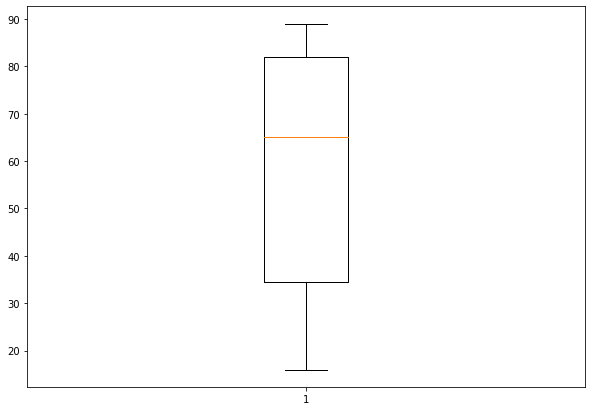

In [52]:
%matplotlib inline
age_quantiles.append(16)
age_quantiles.append(89)
import matplotlib.pyplot as plt
import numpy as np
fig = plt.figure(figsize =(10, 7))
plt.boxplot(age_quantiles)
plt.show()

In [43]:
from pyspark.sql.functions import countDistinct
#df02 = df.select(countDistinct("ethnicity"))
#df.distinct().count()
df.groupBy('ethnicity').count().show()
df.groupBy('gender').count().show()
df.groupBy('ethnicity', 'gender', 'aids').count().show()
df.groupBy('ethnicity', 'gender', 'cirrhosis').count().show()
df.groupBy('ethnicity', 'gender', 'diabetes_mellitus').count().show()
df.groupBy('ethnicity', 'gender', 'hepatic_failure').count().show()
df.groupBy('ethnicity', 'gender', 'immunosuppression').count().show()
df.groupBy('ethnicity', 'gender', 'leukemia').count().show()
df.groupBy('ethnicity', 'gender', 'lymphoma').count().show()
#df.groupBy('age').count().show()
#df.groupBy('bmi').count().show()

+----------------+-----+
|       ethnicity|count|
+----------------+-----+
|       Caucasian|44389|
| Native American|  528|
|African American| 6173|
|        Hispanic| 2390|
|           Asian|  659|
|   Other/Unknown| 2796|
+----------------+-----+

+------+-----+
|gender|count|
+------+-----+
|     F|25971|
|     M|30964|
+------+-----+

+----------------+------+----+-----+
|       ethnicity|gender|aids|count|
+----------------+------+----+-----+
|       Caucasian|     F|   0|20221|
|           Asian|     F|   0|  292|
|   Other/Unknown|     F|   1|    1|
|       Caucasian|     M|   0|24138|
| Native American|     M|   0|  276|
|        Hispanic|     M|   0| 1308|
|        Hispanic|     M|   1|    1|
|           Asian|     M|   0|  367|
|African American|     F|   1|    8|
|       Caucasian|     M|   1|   27|
|   Other/Unknown|     M|   0| 1639|
|       Caucasian|     F|   1|    3|
|        Hispanic|     F|   0| 1079|
|African American|     M|   0| 3192|
|   Other/Unknown|     F|   0

In [34]:
df.agg({'bmi': 'avg'}).show()
df.agg({'bmi': 'min'}).show()
df.agg({'bmi': 'max'}).show()

+------------------+
|          avg(bmi)|
+------------------+
|29.288533945546742|
+------------------+

+-----------+
|   min(bmi)|
+-----------+
|14.84492591|
+-----------+

+-----------+
|   max(bmi)|
+-----------+
|67.81498973|
+-----------+



In [39]:
bmi_quantiles = df.approxQuantile("bmi", [0.25, 0.5, 0.75], 0)
print(bmi_quantiles)

[23.70471503, 27.76812618, 33.06205742]


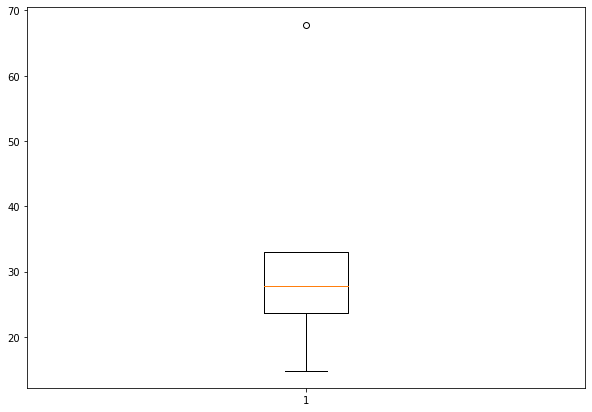

In [53]:
%matplotlib inline
bmi_quantiles.append(14.84492591)
bmi_quantiles.append(67.81498973)
fig = plt.figure(figsize =(10, 7))
plt.boxplot(bmi_quantiles)
plt.show()

In [7]:
df_2 = df.drop("ethnicity", "gender", "icu_admit_source", "icu_type", "apache_3j_bodysystem", "apache_2_bodysystem")
df_2.printSchema()

root
 |-- age: integer (nullable = true)
 |-- bmi: double (nullable = true)
 |-- elective_surgery: integer (nullable = true)
 |-- height: double (nullable = true)
 |-- pre_icu_los_days: double (nullable = true)
 |-- weight: double (nullable = true)
 |-- apache_2_diagnosis: integer (nullable = true)
 |-- apache_3j_diagnosis: double (nullable = true)
 |-- apache_post_operative: integer (nullable = true)
 |-- arf_apache: integer (nullable = true)
 |-- gcs_eyes_apache: integer (nullable = true)
 |-- gcs_motor_apache: integer (nullable = true)
 |-- gcs_unable_apache: integer (nullable = true)
 |-- gcs_verbal_apache: integer (nullable = true)
 |-- heart_rate_apache: integer (nullable = true)
 |-- intubated_apache: integer (nullable = true)
 |-- map_apache: integer (nullable = true)
 |-- resprate_apache: double (nullable = true)
 |-- temp_apache: double (nullable = true)
 |-- ventilated_apache: integer (nullable = true)
 |-- d1_diasbp_max: integer (nullable = true)
 |-- d1_diasbp_min: integer

In [8]:
from pyspark.ml.feature import VectorAssembler, StandardScaler

#feature_columns = df_2.select([c for c in df_2.columns if c not in {'hospital_death'}])
#feature_columns.take(1)

va = VectorAssembler(inputCols=[c for c in df_2.columns if c not in {'hospital_death'}], outputCol="features")  
output = va.transform(df_2)
scaler = StandardScaler(
    inputCol = 'features', 
    outputCol = 'scaledFeatures',
    withMean = True,
    withStd = True
).fit(output)

# when we transform the dataframe, the old
# feature will still remain in it
df_scaled = scaler.transform(output)
df_scaled.take(5)

[Row(age=68, bmi=22.73, elective_surgery=0, height=180.3, pre_icu_los_days=0.541666667, weight=73.9, apache_2_diagnosis=113, apache_3j_diagnosis=502.01, apache_post_operative=0, arf_apache=0, gcs_eyes_apache=3, gcs_motor_apache=6, gcs_unable_apache=0, gcs_verbal_apache=4, heart_rate_apache=118, intubated_apache=0, map_apache=40, resprate_apache=36.0, temp_apache=39.3, ventilated_apache=0, d1_diasbp_max=68, d1_diasbp_min=37, d1_diasbp_noninvasive_max=68, d1_diasbp_noninvasive_min=37, d1_heartrate_max=119, d1_heartrate_min=72, d1_mbp_max=89, d1_mbp_min=46, d1_mbp_noninvasive_max=89, d1_mbp_noninvasive_min=46, d1_resprate_max=34, d1_resprate_min=10, d1_spo2_max=100, d1_spo2_min=74, d1_sysbp_max=131, d1_sysbp_min=73, d1_sysbp_noninvasive_max=131, d1_sysbp_noninvasive_min=73.0, d1_temp_max=39.9, d1_temp_min=37.2, h1_diasbp_max=68, h1_diasbp_min=63, h1_diasbp_noninvasive_max=68, h1_diasbp_noninvasive_min=63, h1_heartrate_max=119, h1_heartrate_min=108, h1_mbp_max=86, h1_mbp_min=85, h1_mbp_non

In [12]:
# Subsetting data by type of data for EDA purposes
#integer_data = data.select([data.dtypes[i][0] for i in range(len(data.dtypes)) if (data.dtypes[i][1] == 'int') and (data.select(data[i]).distinct().count() >= 10)])

#for i in integer_data.columns:
#    integer_data.describe(i).show()
#    integer_data.select(F.percentile_approx(i, [0.25, 0.75], 100000).alias("quantiles")).show()

In [10]:
# hospital_deaths = data.select("hospital_death").filter(col("hospital_death")==1 | col("hospital_death")).groupBy("hospital_death").count()
# hospital_deaths = hospital_deaths.withColumn('percent', )
# hospital_deaths.show()

In [ ]:
# data.hospital_deaths.show()

In [ ]:
# data.select("hospital_death").show()

### Principal Component Analysis (PCA)

In [15]:
from pyspark.ml.feature import PCA

# PCA using 4 components
pca = PCA(k=6, inputCol="scaledFeatures", outputCol="pcaFeatures")
model = pca.fit(df_scaled)

# extract the transformed features
result = model.transform(df_scaled)

result.take(1)

[Row(age=68, bmi=22.73, elective_surgery=0, height=180.3, pre_icu_los_days=0.541666667, weight=73.9, apache_2_diagnosis=113, apache_3j_diagnosis=502.01, apache_post_operative=0, arf_apache=0, gcs_eyes_apache=3, gcs_motor_apache=6, gcs_unable_apache=0, gcs_verbal_apache=4, heart_rate_apache=118, intubated_apache=0, map_apache=40, resprate_apache=36.0, temp_apache=39.3, ventilated_apache=0, d1_diasbp_max=68, d1_diasbp_min=37, d1_diasbp_noninvasive_max=68, d1_diasbp_noninvasive_min=37, d1_heartrate_max=119, d1_heartrate_min=72, d1_mbp_max=89, d1_mbp_min=46, d1_mbp_noninvasive_max=89, d1_mbp_noninvasive_min=46, d1_resprate_max=34, d1_resprate_min=10, d1_spo2_max=100, d1_spo2_min=74, d1_sysbp_max=131, d1_sysbp_min=73, d1_sysbp_noninvasive_max=131, d1_sysbp_noninvasive_min=73.0, d1_temp_max=39.9, d1_temp_min=37.2, h1_diasbp_max=68, h1_diasbp_min=63, h1_diasbp_noninvasive_max=68, h1_diasbp_noninvasive_min=63, h1_heartrate_max=119, h1_heartrate_min=108, h1_mbp_max=86, h1_mbp_min=85, h1_mbp_non

In [16]:
import numpy as np

np.round(100.00*model.explainedVariance.toArray(),4)

array([17.9837,  7.9817,  5.9504,  4.8838,  4.2336,  3.3038])

In [17]:
result_pca_features = result.select("pcaFeatures")
result_pca_features.show(truncate=False)

+------------------------------------------------------------------------------------------------------------------------+
|pcaFeatures                                                                                                             |
+------------------------------------------------------------------------------------------------------------------------+
|[-2.554579499394124,1.3602848303745199,2.4021721006737646,0.5021345963009382,1.525709400699186,0.7840188373034194]      |
|[-4.655509364468678,5.986217339663526,-0.4619628766304875,0.938155483548456,-1.5698352528607848,1.012697196258925]      |
|[5.060960467843136,-0.920954487573992,0.431311206554511,0.20006160407167595,0.3643761374586197,0.38570579551493556]     |
|[-0.43415342801358187,-2.618540374427933,-0.4442655530094939,-1.301590307397434,1.7009940581777845,0.5535308627332085]  |
|[2.2200852195089444,1.749936082391376,-1.7506779775001988,-1.917951283642584,-2.1817924579688937,-0.2771170099932621]   |
|[-2.36628663738

In [23]:
import pandas as pd

cols = df_2.drop('hospital_death').columns
cols

pcs = np.round(model.pc.toArray(),4)
df_pc = pd.DataFrame(pcs, columns = ['PC1','PC2','PC3','PC4','PC5','PC6'], index = cols)
df_pc

PC1     PC2     PC3     PC4     PC5     PC6
age                       -0.0263  0.0135 -0.1041  0.1261 -0.0522  0.1461
bmi                        0.0134  0.0157 -0.0243  0.0334  0.0410  0.3268
elective_surgery          -0.0259 -0.1082 -0.1435 -0.2757  0.2055  0.1807
height                     0.0235 -0.0195 -0.0057 -0.0455 -0.0168  0.1150
pre_icu_los_days          -0.0222  0.0166  0.0072 -0.0655  0.0314  0.0976
...                           ...     ...     ...     ...     ...     ...
genderIndex               -0.0207  0.0245  0.0101  0.0414  0.0349 -0.1132
icu_admit_sourceIndex     -0.0187 -0.0007 -0.0134 -0.0579  0.0804  0.1266
icu_typeIndex             -0.0042 -0.0414 -0.0853 -0.0368  0.0158  0.0780
apache_3j_bodysystemIndex  0.0175 -0.0376  0.0109 -0.1643  0.1902 -0.1252
apache_2_bodysystemIndex   0.0071 -0.0644 -0.0380 -0.2227  0.2098 -0.0801

[78 rows x 6 columns]

In [29]:
pc1 = df_pc.loc[:,'PC1'].abs().sort_values(ascending=False)
s1 = pc1[pc1 > 0.2]
s1

h1_mbp_noninvasive_min       0.2339
h1_mbp_min                   0.2338
h1_mbp_noninvasive_max       0.2274
h1_mbp_max                   0.2271
h1_sysbp_min                 0.2191
h1_sysbp_noninvasive_min     0.2191
h1_sysbp_noninvasive_max     0.2141
h1_diasbp_noninvasive_min    0.2137
h1_diasbp_min                0.2137
h1_sysbp_max                 0.2136
Name: PC1, dtype: float64

In [37]:
s1index=s1.index
s1index

Index(['h1_mbp_noninvasive_min', 'h1_mbp_min', 'h1_mbp_noninvasive_max',
       'h1_mbp_max', 'h1_sysbp_min', 'h1_sysbp_noninvasive_min',
       'h1_sysbp_noninvasive_max', 'h1_diasbp_noninvasive_min',
       'h1_diasbp_min', 'h1_sysbp_max'],
      dtype='object')

In [31]:
pc2 = df_pc.loc[:,'PC2'].abs().sort_values(ascending=False)
s2 = pc2[pc2 > 0.2]
s2

d1_heartrate_max                 0.2308
apache_4a_hospital_death_prob    0.2152
apache_4a_icu_death_prob         0.2044
h1_heartrate_max                 0.2035
Name: PC2, dtype: float64

In [36]:
s2index=s2.index
s2index

Index(['d1_heartrate_max', 'apache_4a_hospital_death_prob',
       'apache_4a_icu_death_prob', 'h1_heartrate_max'],
      dtype='object')

In [33]:
pc3 = df_pc.loc[:,'PC3'].abs().sort_values(ascending=False)
s3 = pc3[pc3 > 0.2]
s3

h1_heartrate_min     0.3320
d1_heartrate_min     0.3039
h1_heartrate_max     0.2887
heart_rate_apache    0.2753
h1_resprate_min      0.2413
d1_heartrate_max     0.2347
d1_resprate_min      0.2167
Name: PC3, dtype: float64

In [38]:
s3index=s3.index
s3index

Index(['h1_heartrate_min', 'd1_heartrate_min', 'h1_heartrate_max',
       'heart_rate_apache', 'h1_resprate_min', 'd1_heartrate_max',
       'd1_resprate_min'],
      dtype='object')

In [41]:
#Union the series indices

s3index.union(s2index).union(s1index)

Index(['apache_4a_hospital_death_prob', 'apache_4a_icu_death_prob',
       'd1_heartrate_max', 'd1_heartrate_min', 'd1_resprate_min',
       'h1_diasbp_min', 'h1_diasbp_noninvasive_min', 'h1_heartrate_max',
       'h1_heartrate_min', 'h1_mbp_max', 'h1_mbp_min',
       'h1_mbp_noninvasive_max', 'h1_mbp_noninvasive_min', 'h1_resprate_min',
       'h1_sysbp_max', 'h1_sysbp_min', 'h1_sysbp_noninvasive_max',
       'h1_sysbp_noninvasive_min', 'heart_rate_apache'],
      dtype='object')